# Fishers test for RB1 and EGFR mutation pathways

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import cptac

In [2]:
gb = cptac.Gbm()

In [4]:
#get RB1 mutations and drop normal samples
RB1_mutations = gb.join_omics_to_mutations(omics_genes=['RB1'], omics_df_name='proteomics', mutations_genes=['RB1'])[['RB1_Mutation_Status','RB1_Mutation']]
RB1_mutations = RB1_mutations.loc[RB1_mutations['RB1_Mutation_Status'] != 'Wildtype_Normal']
#Get EGFR Mutations and drop normal samples
other_gene = 'EGFR' # uses CNV
other_col1 = '%s_Mutation_Status'%other_gene
other_col2 = '%s_Mutation'%other_gene
other_mutations = gb.join_omics_to_mutations(omics_genes=[other_gene], omics_df_name='CNV', mutations_genes=[other_gene])[[other_col1,other_col2]]
other_mutations = other_mutations.loc[other_mutations[other_col1] != 'Wildtype_Normal']

In [5]:
#Concatenate Dataframes
RB1_and_other_Mutations = pd.concat([other_mutations, RB1_mutations], axis=1)[[other_col1,'RB1_Mutation_Status']]
#Classify all mutations as 'mutation' and all wildtypes as 'wildtype'
RB1_and_other_Mutations = RB1_and_other_Mutations.replace({'Wildtype_Tumor':'Wildtype','Single_mutation':'Mutation','Multiple_mutation':'Mutation'})
RB1_and_other_Mutations.groupby(other_col1).count()

Name,RB1_Mutation_Status
EGFR_Mutation_Status,
Mutation,16
Wildtype,84


In [6]:
other_exclusive = '%s_Only'%other_gene
for ind, row in RB1_and_other_Mutations.iterrows():
    if row['RB1_Mutation_Status'] == 'Mutation' and row[other_col1] == 'Mutation':
        RB1_and_other_Mutations.loc[ind, 'Mutation_Exclusivity'] = 'Both'
        
    elif row['RB1_Mutation_Status'] == 'Mutation' and row[other_col1] != 'Mutation':
        RB1_and_other_Mutations.loc[ind, 'Mutation_Exclusivity'] = 'RB1_Only'
        
    elif row['RB1_Mutation_Status'] != 'Mutation' and row[other_col1] == 'Mutation':
        RB1_and_other_Mutations.loc[ind, 'Mutation_Exclusivity'] = other_exclusive
        
    else:
        RB1_and_other_Mutations.loc[ind, 'Mutation_Exclusivity'] = 'Neither'


In [7]:
RB1_and_other_Mutations

Name,EGFR_Mutation_Status,RB1_Mutation_Status,Mutation_Exclusivity
Sample_ID,,,
S001,Wildtype,Mutation,RB1_Only
S002,Mutation,Mutation,Both
S003,Wildtype,Wildtype,Neither
S004,Wildtype,Mutation,RB1_Only
S005,Wildtype,Wildtype,Neither
...,...,...,...
S100,Mutation,Wildtype,EGFR_Only
S101,Wildtype,Wildtype,Neither
S102,Wildtype,Wildtype,Neither


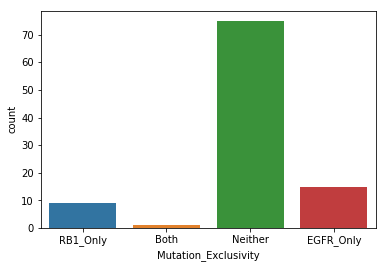

In [8]:
sns.countplot(data=RB1_and_other_Mutations, x='Mutation_Exclusivity')


In [9]:
RB1_only = RB1_and_other_Mutations.loc[RB1_and_other_Mutations['Mutation_Exclusivity'] == 'RB1_Only']
other_only = RB1_and_other_Mutations.loc[RB1_and_other_Mutations['Mutation_Exclusivity'] == other_exclusive]
Neither = RB1_and_other_Mutations.loc[RB1_and_other_Mutations['Mutation_Exclusivity'] == 'Neither']
Both = RB1_and_other_Mutations.loc[RB1_and_other_Mutations['Mutation_Exclusivity'] == 'Both']
print("RB1 Only: ", len(RB1_only))
print("%s Only: "%other_gene, len(other_only))
print("Neither: ", len(Neither))
print("Both: ", len(Both))
oddsratio, pval = scipy.stats.fisher_exact([[len(Both), len(other_only)],[len(RB1_only), len(Neither)]], alternative='less')
pval

RB1 Only:  9
EGFR Only:  15
Neither:  75
Both:  1


0.49977237377795625

Null H: no association for RB1 and EGFR mutation pathways
        

Alternate hypothesis: RB1 and EGFR muation pathways are associated

Because the p-value is not significant, we don't reject the null hypothesis (that there is no association with RB1 and EGFR mutation pathways).

A significant p-value means that there is an association.
"The sum of P-values less than or equal to P_(cutoff)=0.0238 is then 0.0476 which, because it is less than 0.05, is significant. Therefore, in this case, there would be a statistically significant association between the journal and type of article appearing"
http://mathworld.wolfram.com/FishersExactTest.html

This value can be interpreted as the sum of evidence provided by the observed data—or any more extreme table—for the null hypothesis (that there is no difference in the proportions of studiers between men and women). The smaller the value of p, the greater the evidence for rejecting the null hypothesis; so here the evidence is strong that men and women are not equally likely to be studiers. 
https://en.wikipedia.org/wiki/Fisher%27s_exact_test